In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.drop(columns=['id'], inplace=True)

In [3]:
train

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0
...,...,...,...,...,...,...,...,...
749995,male,28,193.0,97.0,30.0,114.0,40.9,230.0
749996,female,64,165.0,63.0,18.0,92.0,40.5,96.0
749997,male,60,162.0,67.0,29.0,113.0,40.9,221.0
749998,male,45,182.0,91.0,17.0,102.0,40.3,109.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Sex         750000 non-null  object 
 1   Age         750000 non-null  int64  
 2   Height      750000 non-null  float64
 3   Weight      750000 non-null  float64
 4   Duration    750000 non-null  float64
 5   Heart_Rate  750000 non-null  float64
 6   Body_Temp   750000 non-null  float64
 7   Calories    750000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 45.8+ MB


In [5]:
X = train.drop(columns=['Calories'])
y = train['Calories']

In [6]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()


print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

Numeric features: ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
Categorical features: ['Sex']


In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop = 'first', sparse_output = False), categorical_features)
    ])

In [8]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42), 
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, eval_metric='rmse')
    }

In [9]:
# -------------------------------
# 6. Initial CV on small sample
# -------------------------------
x = 0.8
sample_frac = x  # 10% sample for initial testing
X_sample = X.sample(frac=sample_frac, random_state=42)
y_sample = y.loc[X_sample.index]

kf = KFold(n_splits=3, shuffle=True, random_state=42)
cv_results = []

for name, model in models.items():
    print(f"Training model: {name}")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    
    # CV RMSE
    mse_scores = cross_val_score(pipeline, X_sample, y_sample, cv=kf, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-mse_scores)
    
    # CV R²
    r2_scores = cross_val_score(pipeline, X_sample, y_sample, cv=kf, scoring='r2', n_jobs=-1)
    
    # Append results for this model
    cv_results.append({
        'Model': name,
        'RMSE Mean': rmse_scores.mean(),
        'R2 Mean': r2_scores.mean(),
        'RMSE Std': rmse_scores.std(),
        'R2 Std': r2_scores.std()
    })

# Create DataFrame and sort
cv_df = pd.DataFrame(cv_results).sort_values(by='RMSE Mean')
print("Initial CV Results on Sample:\n", cv_df)

# Select best model based on RMSE and R2
best_model_name = cv_df.iloc[0]['Model']
best_model = models[best_model_name]

print('-' *100)
print(f"Best model selected: {best_model_name}")

Training model: Linear Regression
Training model: Ridge Regression
Training model: Lasso Regression
Training model: Random Forest
Training model: Gradient Boosting
Training model: XGBoost
Initial CV Results on Sample:
                Model  RMSE Mean   R2 Mean  RMSE Std    R2 Std
5            XGBoost   3.759815  0.996371  0.022035  0.000042
3      Random Forest   3.872725  0.996150  0.038293  0.000075
4  Gradient Boosting   4.697912  0.994335  0.009607  0.000020
0  Linear Regression  11.102155  0.968363  0.024714  0.000127
1   Ridge Regression  11.102155  0.968363  0.024712  0.000127
2   Lasso Regression  11.130876  0.968199  0.023254  0.000119
----------------------------------------------------------------------------------------------------
Best model selected: XGBoost


In [12]:
best_model = XGBRegressor(n_estimators=100, random_state=42, learning_rate=0.1, max_depth=5)


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

try:
    pipelinee = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', best_model)])
        
    pipeline.fit(X_train, y_train)
    print(f"Model training complete")
    y_pred_val = pipeline.predict(X_val)
    mse = mean_squared_error(y_val, y_pred_val)
    mae = mean_absolute_error(y_val, y_pred_val)
    r2 = r2_score(y_val, y_pred_val)
        
    print(f"Validation RMSE: {np.sqrt(mse):,.2f}")
    print(f"Validation MAE: {mae:,.2f}")
    print(f"Validation R2 Score: {r2:.2f}")
    print("--------------------------------------------------------")

        # Apply pipeline to test
    y_pred = pipeline.predict(test)
    print(y_pred)

except Exception as e:
    print(f"An error occurred while training {name}: {e}")

Model training complete
Validation RMSE: 3.73
Validation MAE: 2.29
Validation R2 Score: 1.00
--------------------------------------------------------
[ 26.640532 107.37839   87.30569  ...  72.39798  168.14159   75.8938  ]


In [15]:
y_pred = np.where(y_pred < 0, 0, y_pred)


In [16]:
submission = pd.DataFrame({
    "id" : np.arange(750000, 750000+len(y_pred)),
    "Calories": y_pred
})
submission.to_csv("Calories_submission.csv", index=False)

submission

,id,Calories
0,750000,26.640532
1,750001,107.378387
2,750002,87.305687
3,750003,128.251984
4,750004,75.478691
...,...,...
249995,999995,26.069645
249996,999996,9.199843
249997,999997,72.397980
249998,999998,168.141586


In [17]:
y_pred[np.array(y_pred) < 0]


array([], dtype=float32)

https://www.kaggle.com/competitions/playground-series-s5e5/overview

![I](metric.png)

Final model RMSLE = 0.067

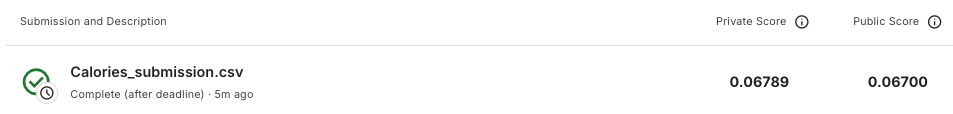

In [19]:
from IPython.display import Image, display

display(Image(filename='results.png'))



In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import numpy as np

# Define RMSLE as a scorer
def rmsle(y_true, y_pred):
    y_pred = np.maximum(0, y_pred)  # avoid negatives
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)  # minimize RMSLE

# Use a smaller sample for hyperparameter tuning (if necessary)
X_sample = X.sample(frac=0.2, random_state=42)
y_sample = y.loc[X_sample.index]

# XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Hyperparameter grid
param_dist = {
    'model__n_estimators': [100, 300, 500, 800],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__max_depth': [3, 5, 7, 9],
    'model__min_child_weight': [1, 3, 5],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0, 0.1, 0.5, 1],
    'model__reg_alpha': [0, 0.1, 1],
    'model__reg_lambda': [1, 1.5, 2]
}

# Train-validation split
# X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

# Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,           # number of random combinations
    scoring=rmsle_scorer,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the best params into best model
try:
    random_search.fit(X_train, y_train)
    print("Hyperparameter tuning complete")
    print("Best Parameters:", random_search.best_params_)
    
    # Validation predictions
    y_pred_val = random_search.predict(X_val)
    mse = mean_squared_error(y_val, y_pred_val)
    mae = mean_absolute_error(y_val, y_pred_val)
    r2 = r2_score(y_val, y_pred_val)
    
    print(f"Validation RMSE: {np.sqrt(mse):,.2f}")
    print(f"Validation MAE: {mae:,.2f}")
    print(f"Validation R2 Score: {r2:.2f}")
    
    # Apply to test set
    y_pred_test = random_search.predict(test)
    print("Test predictions:", y_pred_test)

except Exception as e:
    print(f"An error occurred: {e}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END model__colsample_bytree=0.6, model__gamma=1, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=5, model__n_estimators=300, model__reg_alpha=0, model__reg_lambda=1, model__subsample=0.6; total time=  22.3s
[CV] END model__colsample_bytree=0.6, model__gamma=1, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=5, model__n_estimators=300, model__reg_alpha=0, model__reg_lambda=1, model__subsample=0.6; total time=  23.1s
[CV] END model__colsample_bytree=0.6, model__gamma=1, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=5, model__n_estimators=300, model__reg_alpha=0, model__reg_lambda=1, model__subsample=0.6; total time=  23.4s
[CV] END model__colsample_bytree=1.0, model__gamma=0.5, model__learning_rate=0.2, model__max_depth=7, model__min_child_weight=1, model__n_estimators=300, model__reg_alpha=1, model__reg_lambda=1, model__subsample=0.8; total time=  29.

# Hyperparameter tuning : 20min
Hyperparameter tuning complete

Best Parameters: {'model__subsample': 1.0, 'model__reg_lambda': 2, 'model__reg_alpha': 1, 'model__n_estimators': 800, 'model__min_child_weight': 5, 'model__max_depth': 9, 'model__learning_rate': 0.01, 'model__gamma': 1, 'model__colsample_bytree': 1.0}

Validation RMSE: 3.59

Validation MAE: 2.15

Validation R2 Score: 1.00

Test predictions: [ 27.740273 107.379456  87.21333  ...  72.8015   168.81332   77.13557 ]

In [26]:
y_pred_test[np.array(y_pred_test) < 0]
# convert to 0
y_pred_test = np.where(y_pred_test < 0, 0, y_pred_test)

In [27]:
submission2 = pd.DataFrame({
    "id" : np.arange(750000, 750000+len(y_pred_test)),
    "Calories": y_pred_test
})
submission2.to_csv("Calories_submission2.csv", index=False)

submission2

,id,Calories
0,750000,27.740273
1,750001,107.379456
2,750002,87.213333
3,750003,126.392685
4,750004,76.284248
...,...,...
249995,999995,26.047293
249996,999996,9.192138
249997,999997,72.801498
249998,999998,168.813324


In [25]:
y_pred_test[np.array(y_pred_test) < 0]
# convert to 0
y_pred_test = np.where(y_pred_test < 0, 0, y_pred_test)

Second submission after hyperparameter tuning! 

Better score than first submission.


In [32]:
model_scoreing = pd.DataFrame({
    "Model" : ["Before Hyperparameter Tuning", "After Hyperparameter Tuning"],
    "Validation RMSE" : ["3.73", "3.59"],
    "Validation MAE" : ["2.29", "2.15"],
    "Validation R2 Score" : ["1.00", "1.00"]})

model_scoreing

,Model,Validation RMSE,Validation MAE,Validation R2 Score
0,Before Hyperparameter Tuning,3.73,2.29,1.00
1,After Hyperparameter Tuning,3.59,2.15,1.00


# Model after hyperparam tuning
![metric2](metric2.png)

# Model before hyperparam tuning
![metric1](results.png)